# Sen1Floods11 Dataset

In [1]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os
from skimage.io import imread, imshow
import numpy as np
import pandas as pd
import seaborn as sns
import df_utils
from pytorch_lightning import seed_everything
from sklearn.model_selection import train_test_split

ROOT = os.path.dirname(os.getcwd())
print(ROOT)

/home/genrev_kiel_hizon/SAR_flood_segmentation


In [2]:
HAND_LABELED = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'HandLabeled')
WEAKLY_LABELED = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'WeaklyLabeled')

hl_folders = ['JRCWaterHand', 'LabelHand', 'S1Hand', 'S1OtsuLabelHand', 'S2Hand']
wl_folders = ['S1OtsuLabelWeak', 'S1Weak', 'S2IndexLabelWeak']

## Generating the annotation CSV

### Hand Labeled

Train test split is already provided for the Hand Labeled images. Process the CSVs such that Region and the unique Image Id is left. The file path can be reconstructed during loading. Additionally, add the Bolivia images as the "hold out" set.

In [3]:
for folder in hl_folders:
    hl_images = glob(f'{os.path.join(HAND_LABELED, folder)}/*.tif')
    hl_images = [hl_image.split('/')[8].replace(f'_{folder}.tif', '') for hl_image in hl_images]
    print(f'{folder}: {len(hl_images)}')

JRCWaterHand: 446
LabelHand: 446
S1Hand: 446
S1OtsuLabelHand: 446
S2Hand: 446


In [4]:
SPLITS = ['test', 'train', 'valid']
hand_labeled = pd.DataFrame()
for SPLIT in SPLITS:
    FILE = os.path.join(ROOT, 'sen1floods11', f'flood_{SPLIT}_data.csv')
    hl = pd.read_csv(FILE, header=None)
    hl['Region'] = hl[0].str.split('_', expand=True)[0]
    hl['Img_Id'] = hl[0].str.split('_', expand=True)[1]
    hl['Split'] = SPLIT
    hl.drop(columns=[0,1], inplace=True)
    hand_labeled = pd.concat([hand_labeled, hl])

In [5]:
bolivia = glob(f'{os.path.join(HAND_LABELED, folder)}/Bolivia*.tif')
bolivia = [img.split('/')[8].replace(f'_{folder}.tif', '') for img in bolivia]
img_ids = [img.split('_')[1] for img in bolivia]

bolivia_df = pd.DataFrame({
    'Region': ['Bolivia'] * len(img_ids),
    'Img_Id': img_ids,
    'Split': ['hold out'] * len(img_ids)
})

hand_labeled = pd.concat([hand_labeled, bolivia_df])
hand_labeled.sample(10)

,Region,Img_Id,Split
57,Somalia,61368,valid
81,USA,1039203,valid
53,India,91379,train
139,Paraguay,339807,train
19,India,80221,test
9,Ghana,277,valid
63,Spain,5650136,test
108,Pakistan,211386,train
12,Bolivia,76104,hold out
73,Sri-Lanka,101973,valid


In [6]:
hand_labeled.to_csv(os.path.join(ROOT, 'sen1floods11', 'hand_labeled.csv'))

### Weak Labeled
For the weak labeled images, there we use train_test_split to get an 80:20 split. No test set here because we will also use the handlabeled test set. We remove all Bolivia images here too.

In [7]:
for folder in wl_folders:
    hl_images = glob(f'{os.path.join(WEAKLY_LABELED, folder)}/*.tif')
    hl_images = [hl_image.split('/')[8].replace(f'_{folder}.tif', '') for hl_image in hl_images]
    print(f'{folder}: {len(hl_images)}')

S1OtsuLabelWeak: 4384
S1Weak: 4384
S2IndexLabelWeak: 4384


In [8]:
hl_images = glob(f'{os.path.join(WEAKLY_LABELED, folder)}/*.tif')
hl_images = [hl_image.split('/')[8].replace(f'_{folder}.tif', '') for hl_image in hl_images]
weak_labeled = pd.DataFrame({
    'Region': [hl_image.split('_')[0] for hl_image in hl_images],
    'Img_Id': [hl_image.split('_')[1] for hl_image in hl_images],
})

weak_labeled.sample(10)
weak_labeled = weak_labeled.loc[weak_labeled['Region'] !='Bolivia']
train, valid = train_test_split(weak_labeled, test_size=0.2, stratify=weak_labeled['Region'], random_state=42)

train['Split'] = 'train'
valid['Split'] = 'valid'

weak_labeled = pd.concat([train, valid])
weak_labeled.sample(10)

,Region,Img_Id,Split
1735,Mekong,8472711,train
4101,USA,6481276,train
2678,Colombia,1221590,train
281,Mekong,5269434,train
3172,India,959294,train
1679,Mekong,6784669,train
2435,Pakistan,8656077,train
1514,Mekong,1099620,valid
2187,India,7423357,train
3203,Mekong,9805757,train


In [9]:
weak_labeled.to_csv(os.path.join(ROOT, 'sen1floods11', 'weak_labeled.csv'))

## Visualization

In [10]:
hand_labeled['Label'] = 'hand_labeled'
weak_labeled['Label'] = 'weak_labeled'

all_data = pd.concat([hand_labeled, weak_labeled])
all_data.sample(5)

,Region,Img_Id,Split,Label
1520,India,7011567,valid,weak_labeled
2076,USA,5244420,valid,weak_labeled
2620,Mekong,72758,valid,weak_labeled
2527,Mekong,8487498,train,weak_labeled
2755,Mekong,66901,train,weak_labeled


In [11]:
# Check that no same 'chip' is shared between splits or labels
all_data[all_data[['Region', 'Img_Id']].duplicated(keep=False)]

,Region,Img_Id,Split,Label


In [12]:
hand_labeled['Split'].value_counts().sort_values(ascending=True).keys()

Index(['hold out', 'valid', 'test', 'train'], dtype='object')

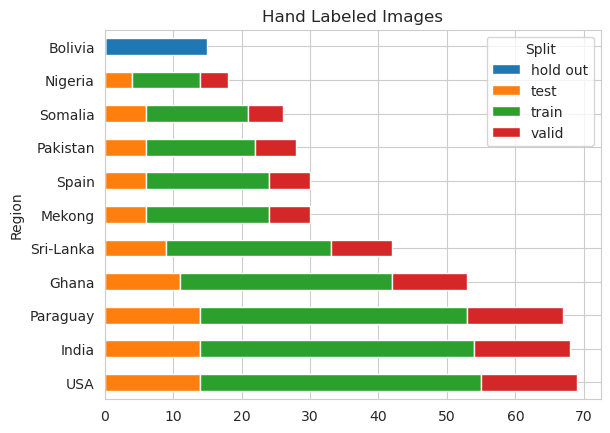

In [13]:
sns.set_style('whitegrid')
# g = sns.histplot(data=hand_labeled, y='Region', hue='Split', multiple='stack', shrink=0.8)
g = hand_labeled.groupby(['Split', 'Region']).size().reset_index().pivot(columns='Split', index='Region', values=0).sort_values('train', ascending=False)
g.plot(kind='barh', stacked=True)
plt.title('Hand Labeled Images')
plt.show()

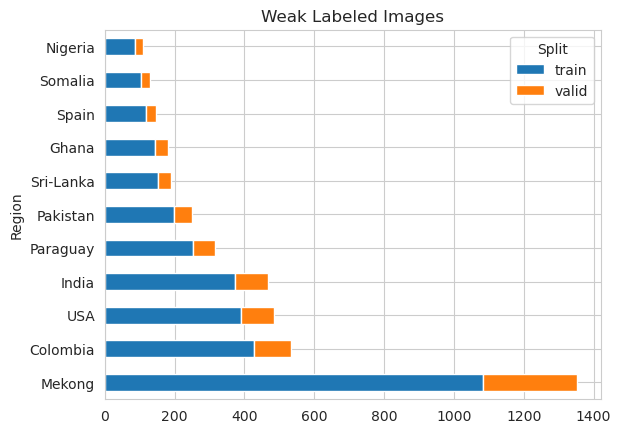

In [14]:
g = weak_labeled.groupby(['Split', 'Region']).size().reset_index().pivot(columns='Split', index='Region', values=0).sort_values('train', ascending=False)
g.plot(kind='barh', stacked=True)
plt.title('Weak Labeled Images')
plt.show()

## Computing the Mean and Standard Deviation

In [15]:
def get_mean_std(row, ROOT, folder):
    if row['Split'] == 'train':
        path = os.path.join(ROOT, folder, f'{row["Region"]}_{row["Img_Id"]}_{folder}.tif')
        img = imread(path)
        row['Ch1_Mean'] = np.mean(img[0])
        row['Ch1_StdDev'] = np.std(img[0])
        row['Ch2_Mean'] = np.mean(img[1])
        row['Ch2_StdDev'] = np.std(img[1])
        # row['InvalidPx'] = np.isnan(img).sum()
    return row

hand_labeled = hand_labeled.apply(lambda row: get_mean_std(row, HAND_LABELED, 'S1Hand'), axis=1)

hand_labeled.sample(5)

,Img_Id,InvalidPx,Label,Region,Split
27,474783,NaN,hand_labeled,Mekong,valid
13,747992,NaN,hand_labeled,India,test
53,91379,0.0,hand_labeled,India,train
37,534470,0.0,hand_labeled,India,train
62,7558720,NaN,hand_labeled,Spain,test


In [22]:
path = os.path.join(ROOT, folder, f'{row["Region"]}_{row["Img_Id"]}_{folder}.tif')

,Img_Id,InvalidPx,Label,Region,Split
0,313799,NaN,hand_labeled,Ghana,test
1,1078550,NaN,hand_labeled,Ghana,test
2,97059,NaN,hand_labeled,Ghana,test
3,359826,NaN,hand_labeled,Ghana,test
4,319168,NaN,hand_labeled,Ghana,test
...,...,...,...,...,...
10,294583,NaN,hand_labeled,Bolivia,hold out
11,312675,NaN,hand_labeled,Bolivia,hold out
12,76104,NaN,hand_labeled,Bolivia,hold out
13,379434,NaN,hand_labeled,Bolivia,hold out


In [16]:
# weak_labeled = weak_labeled.apply(lambda row: get_mean_std(row, WEAKLY_LABELED, 'S1Weak'), axis=1)
# weak_labeled.sample(5)

,Img_Id,InvalidPx,Label,Region,Split
98,5197713,0.0,weak_labeled,India,train
1650,4579290,0.0,weak_labeled,Mekong,train
2055,2923887,0.0,weak_labeled,Paraguay,train
2667,367813,0.0,weak_labeled,Colombia,train
556,4617667,NaN,weak_labeled,Ghana,valid


In [17]:
# import json
# stats = {
#     'HandLabeled': {
#         'Ch1': {
#             'Mean': hand_labeled['Ch1_Mean'].mean(),
#             'Std': hand_labeled['Ch1_StdDev'].mean()
#         },
#         'Ch2': {
#             'Mean': hand_labeled['Ch2_Mean'].mean(),
#             'Std': hand_labeled['Ch2_StdDev'].mean()
#         } 
#     },
#     'WeaklyLabeled': {
#         'Ch1': {
#             'Mean': weak_labeled['Ch1_Mean'].mean(),
#             'Std': weak_labeled['Ch1_StdDev'].mean()
#         },
#         'Ch2': {
#             'Mean': weak_labeled['Ch2_Mean'].mean(),
#             'Std': weak_labeled['Ch2_StdDev'].mean()
#         } 
#     }
# }

# with open(os.path.join(ROOT, 'sen1floods11', 'mean_std.json'), 'w') as f:
#     f.write(json.dumps(stats, indent=4))

In [18]:
# import gdown
# URL = 'https://drive.google.com/drive/folders/1epo0cP6RQyH5BI2SJJzZZRFtnZXa6jpJ'
# gdown.download_folder(URL, quiet=True)